# Settings, Directory Specs, and Imports

In [1]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime


matplotlib.rcParams.update({'font.size': 22})

# Function Definitions

In [2]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

# Defining X and y

In [3]:
Xy = pd.read_csv(dir_read + 'Xy_2020_06_12_1524.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
X.columns.shape

(30,)

In [4]:
cols = list(X.columns)

In [5]:
vars_categ = ['gender_Female', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', \
             'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',\
             'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', \
             'immunosuppression', 'cirrhosis', 'activetx', 'ima', 'midur',
             'oobventday1', 'oobintubday1', 'diabetes']
vars_cont = ['age', 'admissionweight', 'admissionheight', 'bmi', \
             'verbal', 'motor', 'eyes', 'visitnumber', 'heartrate']
print('There are ' + str(len(vars_categ)) + ' categorical features')
print('There are ' + str(len(vars_cont)) + ' continuous features')

There are 21 categorical features
There are 9 continuous features


In [6]:
X = pd.concat([X[vars_cont], X[vars_categ]] ,axis=1)

In [7]:
X

,age,admissionweight,admissionheight,bmi,verbal,motor,eyes,visitnumber,heartrate,gender_Female,...,metastaticcancer,leukemia,immunosuppression,cirrhosis,activetx,ima,midur,oobventday1,oobintubday1,diabetes
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,70,84.3,152.4,36.295906,5,6,4,1,125.052830,1,...,0,0,0,0,1,0,0,0,0,0
141194,68,73.9,180.3,22.732803,4,6,3,1,86.860627,0,...,0,0,0,0,0,0,0,0,0,1
141197,71,102.1,162.6,38.617545,5,6,4,1,97.307692,0,...,0,0,0,0,0,0,0,0,0,0
141203,77,70.2,160.0,27.421875,1,3,1,1,91.543554,1,...,0,0,0,0,1,0,0,1,0,1
141208,25,95.3,172.7,31.952749,5,6,3,1,77.817460,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353201,66,71.5,157.5,28.823381,5,6,3,3,79.658451,1,...,0,0,0,0,1,0,0,1,1,0
3353216,50,55.4,165.1,20.324301,1,5,1,1,69.608541,1,...,0,0,0,0,1,0,0,1,1,0
3353235,50,90.0,175.3,29.287256,5,6,4,1,87.089623,0,...,0,0,0,0,0,0,0,0,0,0


# Logistic Regression

In [8]:
def grid_search_wrapper(clf, X_train_sc, y_train, scoring):#, X_test_sc, y_test, scoring):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)    
    
    hyperparam_grid = {'penalty': ['l1', 'l2'], \
                       'C': np.logspace(-6, 3, 10), \
                       #'class_weight': [{0: x,   1: 1-x} for x in weights], \
                       'fit_intercept': [True, False]}
    #GridSearchCV(clf, param, scoring='f1_score',refit=True,cv=10)
    
    grid_search = GridSearchCV(clf, scoring=scoring, param_grid=hyperparam_grid, refit=True,
                           cv=skf, return_train_score=True, n_jobs=4)
    grid_search.fit(X_train_sc, y_train)

    # make the predictions
    #y_pred = grid_search.predict(X_test_sc)

    print('Best params for ' + scoring)
    print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Logistic Regression optimized')
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [9]:
# from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
# scaler = MinMaxScaler()
# X_train_sc = scaler.fit_transform(X_train[vars_cont])
# X_test_sc = scaler.transform(X_test[vars_cont])

# from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
# scaler = MinMaxScaler()


In [10]:

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
scaler = MinMaxScaler()
# X_train_sc = scaler.fit_transform(X_train[vars_cont])
# X_test_sc = scaler.transform(X_test[vars_cont])

X_train_sc = np.concatenate([scaler.fit_transform(X_train[vars_cont]), \
                             X_train[vars_categ].to_numpy()], axis=1)
X_test_sc = np.concatenate([scaler.fit_transform(X_test[vars_cont]), \
                             X_test[vars_categ].to_numpy()], axis=1)


clf = LogisticRegression(class_weight='balanced')
# clf.fit(X_train_sc, y_train)
#grid_search_clf_rocauc, y_pred_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, X_test_sc, y_test, 'roc_auc')
grid_search_clf_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, 'roc_auc')

Best params for roc_auc
{'C': 0.01, 'fit_intercept': True, 'penalty': 'l2'}


In [11]:
print(X_train_sc)

[[0.70833333 0.08520179 0.44470963 ... 0.         0.         0.        ]
 [0.86111111 0.07679372 0.70723946 ... 1.         1.         0.        ]
 [0.81944444 0.0669843  0.52505967 ... 1.         1.         0.        ]
 ...
 [0.875      0.03783632 0.46459825 ... 0.         0.         0.        ]
 [0.26388889 0.27802691 0.46459825 ... 0.         0.         1.        ]
 [0.69444444 0.12780269 0.52505967 ... 0.         0.         0.        ]]


In [12]:
#C=0.01, fit_intercept=True, penalty='l2'
#C=0.0001, fit_intercept=False, penalty='l2'
clf_w_best_params = LogisticRegression(class_weight = 'balanced', C=0.01, fit_intercept=True, penalty='l2')
clf_w_best_params.fit(X_train_sc, y_train)


model_and_scaler = {'model': clf_w_best_params, 'scaler': scaler}
pickle.dump(model_and_scaler, open('../models/model_scaler_' + now_to_str() + '.pickle', 'wb'))

y_pred = clf_w_best_params.predict(X_test_sc)
y_probs = clf_w_best_params.predict_proba(X_test_sc)[:,1]

print('AUC is ' + str(roc_auc_score(y_test,y_probs)))

AUC is 0.7468511406757189


In [13]:
y_probs.min()

0.052774281933661224

In [14]:
y_probs.max()

0.9699253806896185

(array([  31.,  176.,  528., 1287., 2316., 2848., 2972., 2665., 2392.,
        2177., 1945., 1800., 1722., 1673., 1651., 1428.,  974.,  527.,
         130.,   12.]),
 array([0.05277428, 0.09863184, 0.14448939, 0.19034695, 0.2362045 ,
        0.28206206, 0.32791961, 0.37377717, 0.41963472, 0.46549228,
        0.51134983, 0.55720739, 0.60306494, 0.6489225 , 0.69478005,
        0.74063761, 0.78649516, 0.83235272, 0.87821027, 0.92406783,
        0.96992538]),
 <a list of 20 Patch objects>)

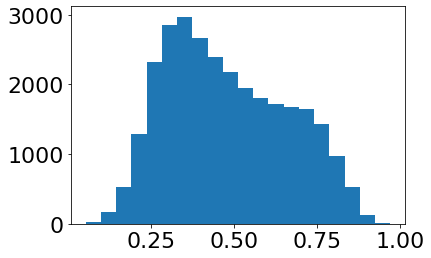

In [15]:
plt.hist(y_probs, bins=20)

Logistic: ROC AUC=0.747


<IPython.core.display.Javascript object>


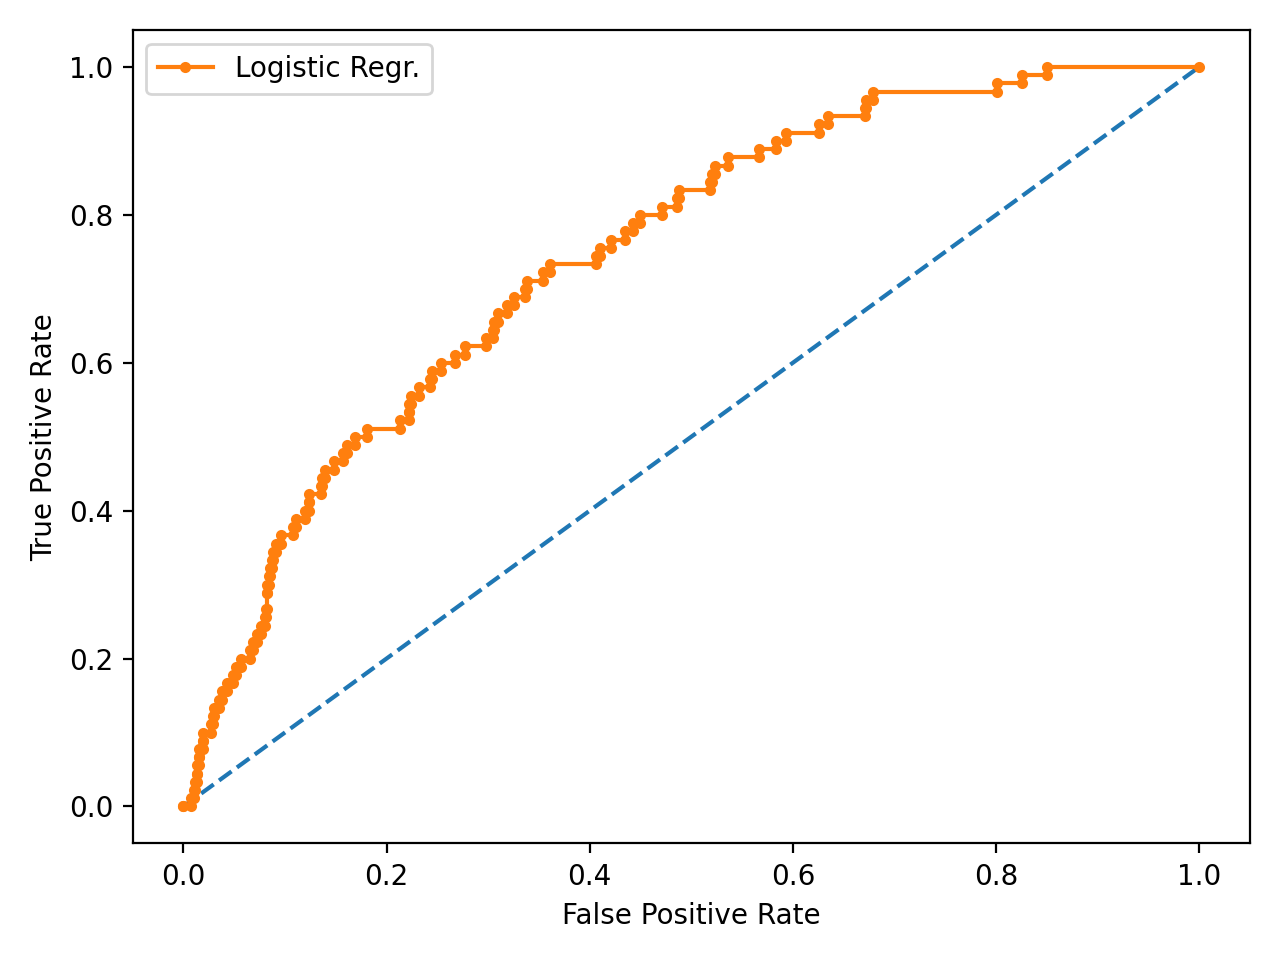

In [22]:
%matplotlib notebook


noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, clf_w_best_params.predict_proba(X_test_sc)[:,1])

y_pred_new = lr_tpr>0

logisticRegr_auc = roc_auc_score(y_test, y_probs)
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
plt.tight_layout()
# # show the plot
plt.show()

In [17]:
# Looking at ROC curve, a TPR of 0.88 and FPR of 0.48 seems reasonable because the prophylaxis may
# cause bleeding, but VTE is deadly, too. Get the threshold at this level
fpr_tpr_thresh = pd.DataFrame({'fpr': lr_fpr, 'tpr': lr_tpr, 'thresh': threshold_array})
fpr_tpr_thresh = fpr_tpr_thresh[(fpr_tpr_thresh['tpr'] < 0.92) & (fpr_tpr_thresh['tpr'] > 0.80)]
fpr_tpr_thresh

,fpr,tpr,thresh
145,0.471026,0.811111,0.470395
146,0.485633,0.811111,0.461482
147,0.485633,0.822222,0.461449
148,0.488170,0.822222,0.459931
149,0.488170,0.833333,0.459845
150,0.518790,0.833333,0.441927
151,0.518790,0.844444,0.441877
152,0.520779,0.844444,0.440908
153,0.520779,0.855556,0.440897
154,0.523488,0.855556,0.439278


In [18]:
# Xt = X_test_sc
# yt = y_test

# THRESHOLD = [0.0017, 0.0018, 0.0019, 0.0020, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027]
# for thresh in THRESHOLD:
#     print('-----------------')
#     print('THRESHOLD =  ' + str(thresh))
#     y_pred_thresh = np.where(clf_w_best_params.predict_proba(Xt)[:,1] > thresh, 1, 0)
#     print('F1: ' + str(f1_score(yt, y_pred_thresh)))
#     print('Precision: ' + str(precision_score(yt, y_pred_thresh)))
#     print('Recall: ' + str(recall_score(yt, y_pred_thresh)))
#     print(confusion_matrix(yt, y_pred_thresh, normalize='true'))

# Feature Weights

In [19]:
# Get feature weights and put into dataframe
mydict = {'feature': X_train.columns, 'coef': list(clf_w_best_params.coef_.reshape(-1,1).flatten())}
features_weights = pd.DataFrame(mydict)
features_weights = features_weights.assign(abs_weight=np.abs(features_weights['coef']))
features_weights.head()

,feature,coef,abs_weight
0,age,0.735094,0.735094
1,admissionweight,1.150666,1.150666
2,admissionheight,0.150494,0.150494
3,bmi,0.909400,0.909400
4,verbal,-0.282390,0.282390


In [20]:
fw = features_weights.sort_values(by='abs_weight', ascending=False)

In [21]:
fw5 = fw.iloc[0:5]
fw5

,feature,coef,abs_weight
8,heartrate,3.281096,3.281096
25,ima,-1.602630,1.602630
1,admissionweight,1.150666,1.150666
3,bmi,0.909400,0.909400
0,age,0.735094,0.735094
